# Overview

The aim of this project is to predict the number of dengue cases in Taipei, Taiwan, using machine learning methods as well as perform Granger causality-assisted feature engineering. Dengue fever is a mosquito-borne infection that is caused by the dengue virus. This virus is primarily transmitted by _Aedes_ moesquitos. 

This project leverages only on historical data to build a predictive model. By incorporating lagged dengue cases, I target to capture the temporal dependencies that influence dengue incidence. Machine learning techniques, such as Artificial neural networks (ANNs) and eXtreme gradient boosting (XGB) models, aim to effectively model these relationships. Hyperparameter optimization through Bayesian methods ensures that the model is fine-tuned for the best performance. Although this project remains in its early stages, I hope this can be a stepping stone for public health officials to help curb the impact of dengue outbreaks in Taiwan.

# Dataset

Data for dengue cases are sourced from Taiwan National Infectious Disease Statistics System [[1]](https://nidss.cdc.gov.tw/en/). The temporal resolution is daily, and will be converted to a weekly counterpart. 

The dengue dataset ranged from January 1, 1998 to December 30, 2024. Dengue cases are reported through the Date of Onset. Furthermore, these cases are of indigenous and imported natures.

# Load necessary libraries

In this project, `pandas`, `scikit-learn` (version 1.5.2), `scikit-optimize`, `xgboost`, and `statsmodels` were some of the libraries that were used.

In [46]:
!pip install scikit-learn==1.5.2 # see https://stackoverflow.com/questions/79290968/super-object-has-no-attribute-sklearn-tags
!pip install scikit-optimize


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import matplotlib.dates as mdates


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


# Load the dataset

In [47]:
taipei_data = pd.read_csv('dengue_taipei/dengue-fever-taipei-indi_impo_daily_19980101_20241230.csv')
taipei_data.head(1)

,Onset Date,Excluded Cases,Cases Pending Laboratory Confirmation,Number of Confirmed Cases
0,19980101,1,0,0


Next, I will convert the dataset from daily to weekly temporal resolution. I used the ISO standard to define what constitutes a week.

Note that the **confirmed dengue cases** were only considered in the dataset.

In [48]:

# First, convert the 'Onset Date' from YYYYMMDD format to datetime
taipei_data['Onset Date'] = pd.to_datetime(taipei_data['Onset Date'], format='%Y%m%d')

# Add a new column for the ISO week number
taipei_data['ISO Week'] = taipei_data['Onset Date'].dt.isocalendar().week

# Add a new column for the ISO year
taipei_data['ISO Year'] = taipei_data['Onset Date'].dt.isocalendar().year

# Create the YEARMONTH column in the format YYYY-WW
taipei_data['YEARMONTH'] = taipei_data['ISO Year'].astype(str) + '-' + taipei_data['ISO Week'].astype(str).str.zfill(2)

# Drop the 'Onset Date' column
taipei_data = taipei_data.drop(columns=['Onset Date', 'Cases Pending Laboratory Confirmation'])

# Group by YEARMONTH and sum the relevant columns
weekly_data = taipei_data.groupby('YEARMONTH').agg({
    'Number of Confirmed Cases': 'sum'
}).reset_index()

weekly_data = weekly_data.rename(columns={'Number of Confirmed Cases': 'num_confirmed'})

# delete taipei_data
del taipei_data

# Display the first few rows to verify the new dataframe
weekly_data.head()

,YEARMONTH,num_confirmed
0,1998-01,0
1,1998-02,0
2,1998-03,1
3,1998-04,2
4,1998-05,1


The ML model that I'll be creating is one that depends on lagged values of dengue cases. Hence, I created new columns for lagged values of dengue cases. 

The incubation period for dengue fever typically ranges from 4 to 10 days, but symptoms can appear up to 14 days after being bitten by an infected mosquito. Given this information, a lag of 2 weeks is appropriate for analyzing the spread and impact of dengue. However, the possiblities of delayed reporting should not be discounted. Therefore, I used lags until 3 weeks.

In [49]:
# Create lagged values for num_confirmed from 1 week to 3 weeks
weekly_data['lagged_conf_1'] = weekly_data['num_confirmed'].shift(1)
weekly_data['lagged_conf_2'] = weekly_data['num_confirmed'].shift(2)
weekly_data['lagged_conf_3'] = weekly_data['num_confirmed'].shift(3)

# Drop rows with NaN values
weekly_data = weekly_data.dropna()

# Display the first few rows to verify the new dataframe
weekly_data.head(1)

,YEARMONTH,num_confirmed,lagged_conf_1,lagged_conf_2,lagged_conf_3
3,1998-04,2,1.0,0.0,0.0


Let's take a look at the visual spread of dengue cases in Taipei, Taiwan.

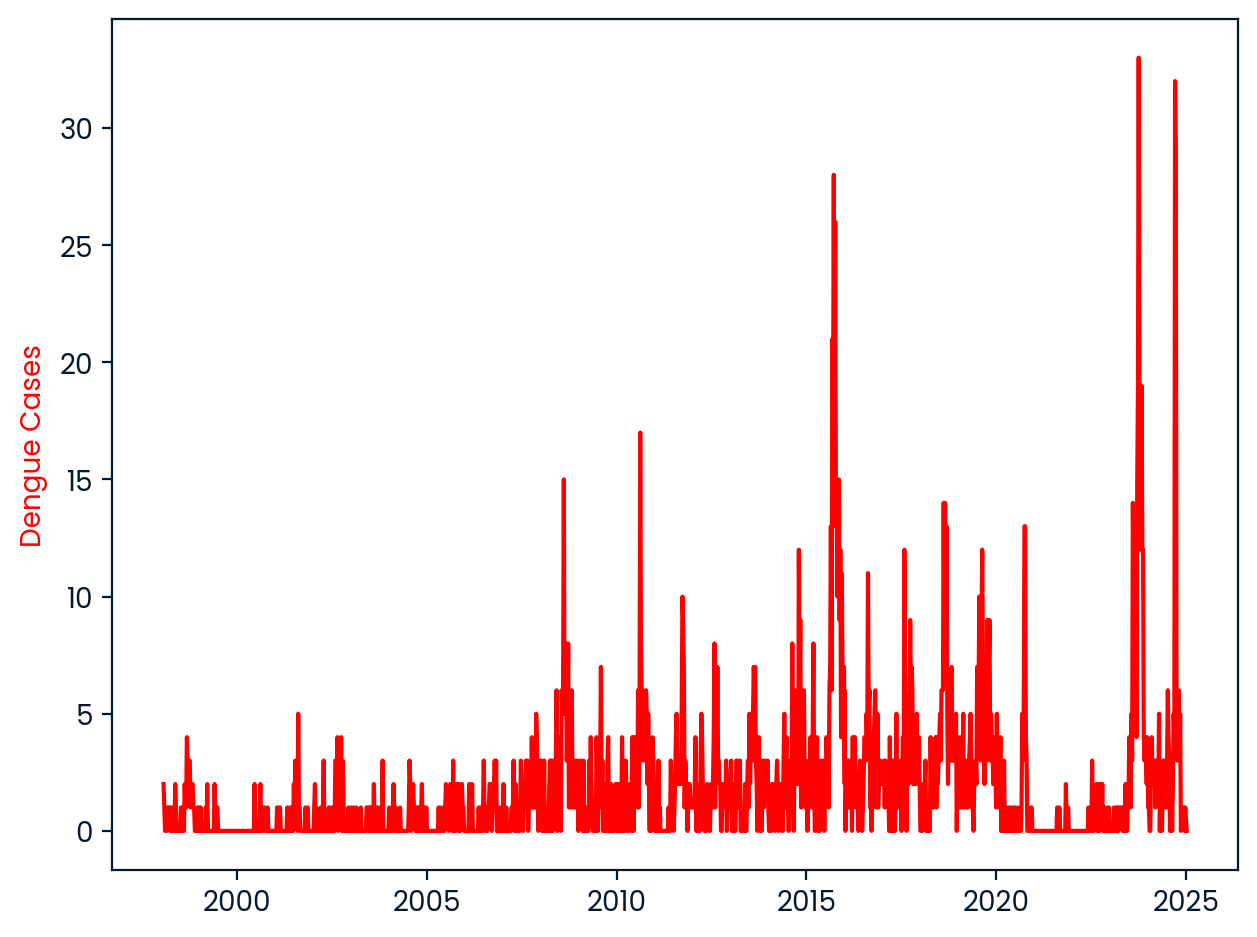

In [50]:
# Convert YEARMONTH to datetime format
weekly_data['YEARMONTH'] = pd.to_datetime(weekly_data['YEARMONTH'] + '-1', format='%Y-%W-%w')

# Create a 3x1 subplot
fig, ax = plt.subplots()

# Plot dengue cases
ax.plot(weekly_data['YEARMONTH'], weekly_data['num_confirmed'], color='red')
ax.set_ylabel('Dengue Cases', color='red')

# Set xticks and labels for each 'YYYY-01' and plot xticks every 5 years
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

# Granger causality-assisted feature engineering

A key part to creating robust ML models is determining the appropriate features. One way to accomplish this is via **Granger Causality** -- a statistical hypothesis test that is used to determine whether one time series can be able to predict another time series. 

Granger causality results are typically interpreted using the _p_-values from the Granger causality test. The null hypothesis of the Granger causality test is that variable (_X_ ) does not Granger-cause variable (_Y_).

_p_-value: The _p_-value indicates the probability that the observed data would occur if the null hypothesis were true.

Here are the following scenarios to take note:

Low _p_-value (< 0.05): Reject the null hypothesis, which suggests that (_X_) Granger-causes (_Y_). Simply put, past values of (_X_) provide statistically significant information about future values of (_Y_).

High _p_-value (≥ 0.05): Fail to reject the null hypothesis, which implies that (_X_) does not Granger-cause (_Y_). Past values of (_X_) do not provide statistically significant information about future values of (_Y_).


In this project, I only considered the lag that yielded the lowest _p_-value, provided that _p_<0.05.

In [51]:
# Prepare data for Granger causality test
# Create a DataFrame with the current and lagged values
granger_data = weekly_data[['num_confirmed', 'lagged_conf_1', 'lagged_conf_2', 'lagged_conf_3']]

# Perform Granger causality test
# The maxlag parameter specifies the maximum number of lags to test
granger_test_result = grangercausalitytests(granger_data[['num_confirmed', 'lagged_conf_1']], maxlag=3, verbose=True)

# Note: If the p<0.05, we reject the null hypothesis that lagged values do not Granger-cause the current values.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=105.4653, p=0.0000  , df_denom=1403, df_num=1
ssr based chi2 test:   chi2=105.6908, p=0.0000  , df=1
likelihood ratio test: chi2=101.9068, p=0.0000  , df=1
parameter F test:         F=105.4653, p=0.0000  , df_denom=1403, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1683  , p=0.0424  , df_denom=1401, df_num=2
ssr based chi2 test:   chi2=6.3547  , p=0.0417  , df=2
likelihood ratio test: chi2=6.3404  , p=0.0420  , df=2
parameter F test:         F=56.0239 , p=0.0000  , df_denom=1401, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.3238  , p=0.0048  , df_denom=1399, df_num=3
ssr based chi2 test:   chi2=13.0177 , p=0.0046  , df=3
likelihood ratio test: chi2=12.9577 , p=0.0047  , df=3
parameter F test:         F=42.0054 , p=0.0000  , df_denom=1399, df_num=3


Results above show that dengue cases at **lag=1 week** will be considered as a feature for the ML model (_p_=0 <0.05). 

The low _p_-value suggests that dengue cases 1 week ago do Granger-cause the current dengue cases.

Prior to ML modeling, a random noise $\in (0.01, 1)$ is added in the dengue cases.

In [52]:
# Add random noise to all columns except 'YEARMONTH'
for col in weekly_data.columns:
    if col != 'YEARMONTH':
        noise = np.random.uniform(0.01, 0.1, size=weekly_data[col].shape)
        weekly_data[col] += noise

# ML modeling

First, I  split the data into training and testing sets to evaluate the model's performance. I then used a `sklearn`-based pipeline to perform log transformation and standardization of the training and testing data.

In this project, I will be using XGBoost with its hyperparameters laid out via Bayesian optimization. 

In [53]:
# Extract features and target
feature_columns = ['lagged_conf_1']
X = weekly_data[feature_columns].to_numpy()
y = weekly_data['num_confirmed'].to_numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def func_ln(x,const=2): return np.log(x+const)

log_transformer = FunctionTransformer(func_ln, validate=True)

# Create a pipeline to standardize the data
pipeline = Pipeline([
    ('log_transform', log_transformer),
    ('scaler', StandardScaler())
])

# Fit and transform the training data
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)


In [54]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
param_space = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, 'log-uniform'),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(0,0.5),
    'subsample': Real(0.5, 1),
    'colsample_bytree': Real(0.5, 1)
}

opt = BayesSearchCV(model, param_space, n_iter=50, cv=5, random_state=42, n_jobs=-1)
opt.fit(X_train_scaled, y_train)

# Train the best model
best_model = opt.best_estimator_
best_model.fit(X_train_scaled, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=237, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Evaluation of model performance

The model performance was evaluated using the following metrics:

**Mean Squared Error (MSE)**: Measures the average squared difference between the actual and predicted values. <br>
**R-squared (R^2)**: Denotes the proportion of the variance in the dependent variable that is predictable from the independent variables. <br>

Mean Squared Error: 4.451222686543394
R^2 Score: 0.549010336297193


<Figure size 640x480 with 0 Axes>

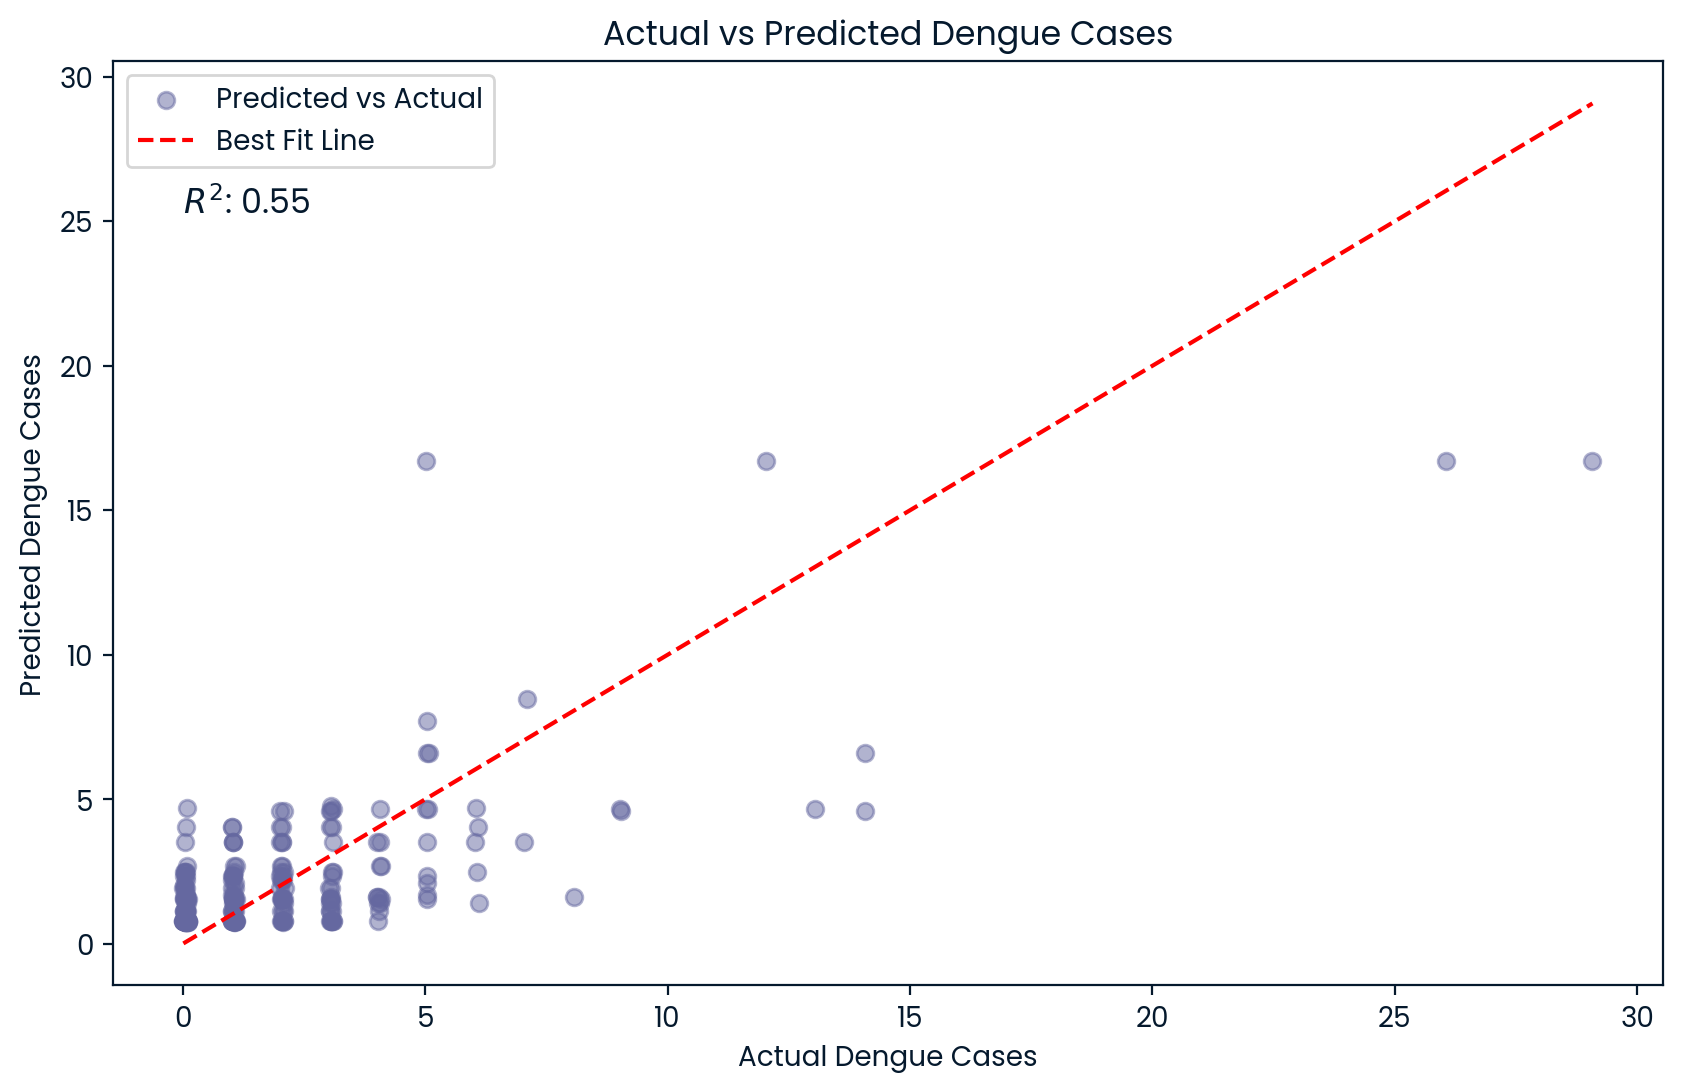

In [55]:

# Make predictions
y_pred = opt.predict(X_test_scaled)
# y_pred = predictions.flatten()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

plt.clf()

# Scatter plot of actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Best Fit Line')
plt.title('Actual vs Predicted Dengue Cases')
plt.xlabel('Actual Dengue Cases')
plt.ylabel('Predicted Dengue Cases')
plt.legend(loc='best')

# Add R^2 value as text
plt.text(min(y_test), 0.9*max(y_test), f'$R^2$: {r2:.2f}', fontsize=12, verticalalignment='top')

plt.show()


Looking at the plot below,  "most" of the spikes were predicted correctly despite the relatively poor $R^{2}$.

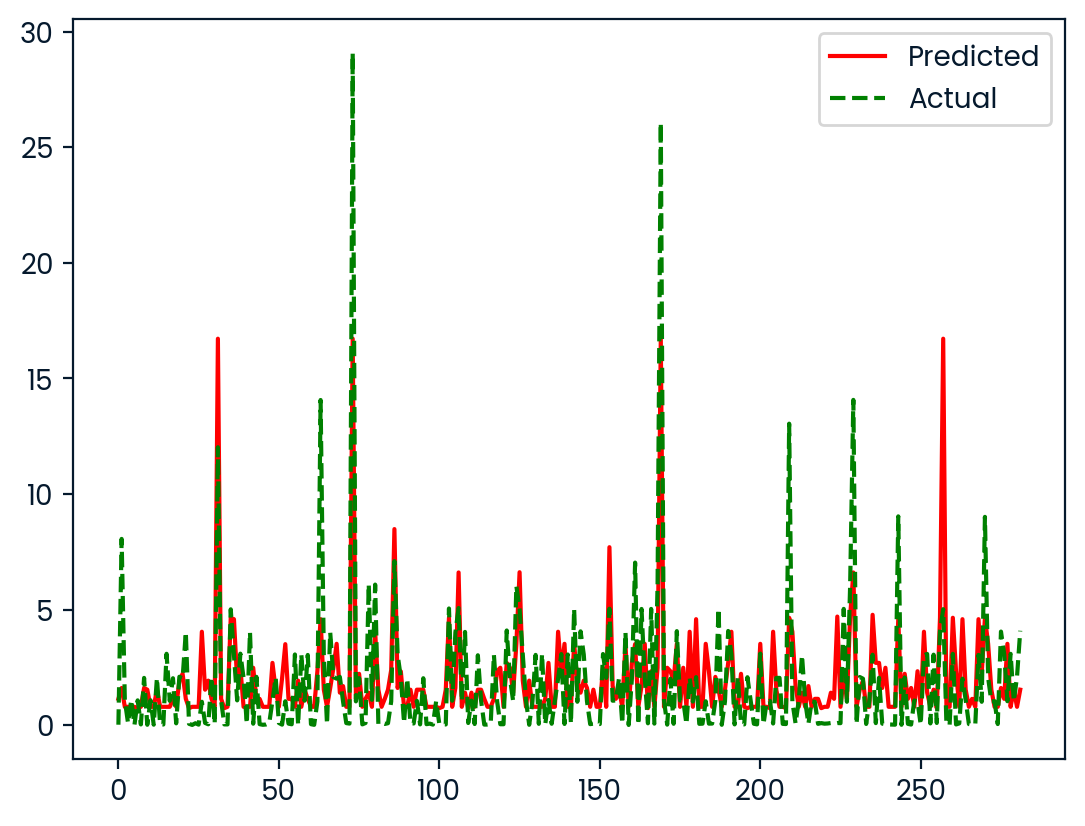

In [56]:
plt.clf()
plt.plot(y_pred, ls='-', color='red', label='Predicted')
plt.plot(y_test, ls='--', color='green', label='Actual')
plt.legend()

Now, if I use ANN with `lbfgs` as the optimization algorithm...

Mean Squared Error, ann: 4.71894793855518
R^2 Score, ann: 0.549010336297193


<Figure size 640x480 with 0 Axes>

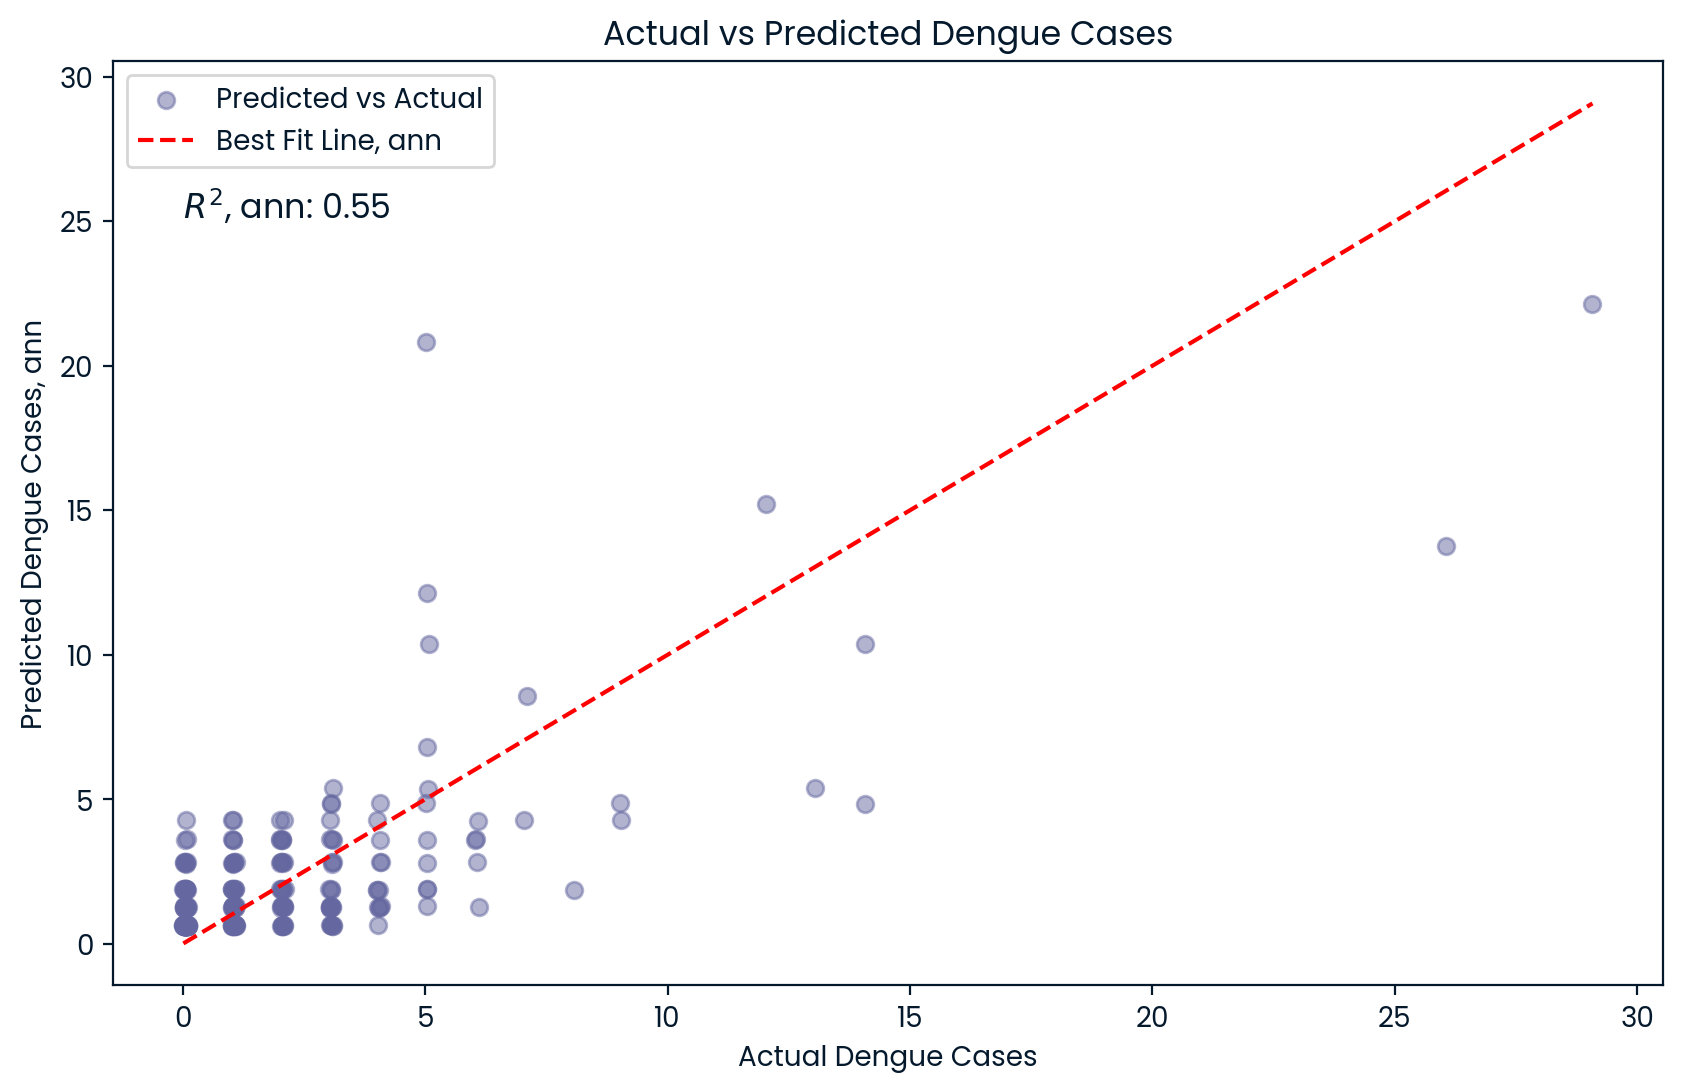

In [57]:


model_ann = MLPRegressor(solver='lbfgs', random_state=42)

# Define the parameter space for Bayesian optimization
param_space_ann = {
    'hidden_layer_sizes': Integer(50, 200),
    'alpha': Real(1e-6, 1e-2, prior='log-uniform'),
    'learning_rate_init': Real(1e-4, 1e-1, prior='log-uniform')
}


# Perform Bayesian optimization
opt_ann = BayesSearchCV(model_ann, param_space_ann, n_iter=50, cv=5, random_state=42, n_jobs=-1)
opt_ann.fit(X_train_scaled, y_train)

# Train the best model
best_model_ann = opt_ann.best_estimator_
best_model_ann.fit(X_train_scaled, y_train)



# Make predictions
y_pred_ann = opt_ann.predict(X_test_scaled)

# Evaluate the model
mse_ann = mean_squared_error(y_test, y_pred_ann)
r2_ann = r2_score(y_test, y_pred_ann)
print(f'Mean Squared Error, ann: {mse_ann}')
print(f'R^2 Score, ann: {r2}')

plt.clf()

# Scatter plot of actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ann, alpha=0.5, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Best Fit Line, ann')
plt.title('Actual vs Predicted Dengue Cases')
plt.xlabel('Actual Dengue Cases')
plt.ylabel('Predicted Dengue Cases, ann')
plt.legend(loc='best')

# Add R^2 value as text
plt.text(min(y_test), 0.9*max(y_test), f'$R^2$, ann: {r2:.2f}', fontsize=12, verticalalignment='top')

plt.show()


...notice that the $R^{2}$ sufficiently close to that using XGB. These results prompted me to explore addition of exogenous variables like rainfall, temperature, and humidity in future runs. 

If you have questions, kindly send them over at jprmaulion[at]gmail[dot]com. Happy holidays everyone!